# 卷积神经网络

## 神经网络遇到的问题
- 普通的神经网络在处理图片的时候会遇到参数过多的问题
- 因为参数过多，所以会产生过拟合问题，需要使用更多的训练数据
- 因为参数过多，所以会导致得到的结果收敛到较差的局部极值

## 卷积神经网络
- 局部连接
- 参数共享
- 输出size = 输入size-卷积核+1
- 卷积--padding使输出size不变

## 卷积 ------ 多个卷积核
- 卷积层，输入三通道，输出192通道，卷积核大小是3*3，问该卷积层有多少参数？

## 卷积-Summary
- P=边距(padding)
- S=步长(stride)
- 输出尺寸 = (n-p)/s+1

# 卷积神经网络的tensorflow实现

In [1]:
import tensorflow as tf

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
print(tf.__version__)

1.10.0


In [3]:
import pickle
import numpy
import os
import numpy as np

In [4]:
os.listdir('./')

['.ipynb_checkpoints',
 '09边缘检测2.ipynb',
 '1.PNG',
 'cifar-10-batches-py',
 'RL强化学习.ipynb',
 '前馈神经网络.ipynb',
 '卷积神经网络实现.ipynb',
 '强化学习.ipynb',
 '神经元.ipynb',
 '神经网络实现.ipynb']

In [5]:
CIFAR_DIR = './cifar-10-batches-py'

In [6]:
os.listdir(CIFAR_DIR)

['batches.meta',
 'data_batch_1',
 'data_batch_2',
 'data_batch_3',
 'data_batch_4',
 'data_batch_5',
 'readme.html',
 'test_batch']

In [7]:
with open(os.path.join(CIFAR_DIR,'data_batch_1'),'rb') as f:
    data = pickle.load(f,encoding='latin1')
    print(type(data))
    print(data.keys())
    print(type(data['data']))
    print(type(data['labels']))
    print(type(data['batch_label']))
    print(type(data['filenames']))
    print(data['data'].shape)
    print(data['data'][0:2])
    print(data['labels'][0:2])
    print(data['batch_label'])
    print(data['filenames'][0:2])

<class 'dict'>
dict_keys(['batch_label', 'labels', 'data', 'filenames'])
<class 'numpy.ndarray'>
<class 'list'>
<class 'str'>
<class 'list'>
(10000, 3072)
[[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]]
[6, 9]
training batch 1 of 5
['leptodactylus_pentadactylus_s_000004.png', 'camion_s_000148.png']


In [8]:
image_arr = data['data'][100]
image_arr = image_arr.reshape((3,32,32))
image_arr = image_arr.transpose((1,2,0))

In [9]:
 import matplotlib.pyplot as plt
%matplotlib inline

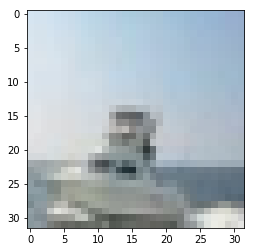

In [10]:
plt.imshow(image_arr)

# 使用神经元对cifar数据进行分类

In [11]:
import tensorflow as tf

In [12]:
def load_data(filename):
    """read data from data file."""
    with open(filename, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
        return data[b'data'], data[b'labels']

# tensorflow.Dataset.
class CifarData:
    def __init__(self, filenames, need_shuffle):
        all_data = []
        all_labels = []
        for filename in filenames:
            data, labels = load_data(filename)
            all_data.append(data)
            all_labels.append(labels)
        self._data = np.vstack(all_data)
        self._data = self._data / 127.5 - 1
        self._labels = np.hstack(all_labels)
        print(self._data.shape)
        print(self._labels.shape)
        
        self._num_examples = self._data.shape[0]
        self._need_shuffle = need_shuffle
        self._indicator = 0
        if self._need_shuffle:
            self._shuffle_data()
            
    def _shuffle_data(self):
        # [0,1,2,3,4,5] -> [5,3,2,4,0,1]
        p = np.random.permutation(self._num_examples)
        self._data = self._data[p]
        self._labels = self._labels[p]
    
    def next_batch(self, batch_size):
        """return batch_size examples as a batch."""
        end_indicator = self._indicator + batch_size
        if end_indicator > self._num_examples:
            if self._need_shuffle:
                self._shuffle_data()
                self._indicator = 0
                end_indicator = batch_size
            else:
                raise Exception("have no more examples")
        if end_indicator > self._num_examples:
            raise Exception("batch size is larger than all examples")
        batch_data = self._data[self._indicator: end_indicator]
        batch_labels = self._labels[self._indicator: end_indicator]
        self._indicator = end_indicator
        return batch_data, batch_labels

train_filenames = [os.path.join(CIFAR_DIR, 'data_batch_%d' % i) for i in range(1, 6)]
test_filenames = [os.path.join(CIFAR_DIR, 'test_batch')]

train_data = CifarData(train_filenames, True)
test_data = CifarData(test_filenames, False)

(50000, 3072)
(50000,)
(10000, 3072)
(10000,)


In [13]:
x = tf.placeholder(tf.float32,[None,3072])
x_image = tf.reshape(x,[-1,3,32,32])
y = tf.placeholder(tf.int64,[None])

In [14]:
# w = tf.get_variable('w',[x.get_shape()[-1],10],initializer=tf.random_normal_initializer(0,1))
# b = tf.get_variable('b',[10],initializer=tf.constant_initializer(0.0))
# y_ = tf.matmul(x,w)+b
# hidden1 = tf.layers.dense(x,100,activation=tf.nn.relu)
# hidden2 = tf.layers.dense(hidden1,100,activation=tf.nn.relu)
# hidden3 = tf.layers.dense(hidden2,50,activation=tf.nn.relu)
x_image = tf.reshape(x,[-1,3,32,32])
x_image = tf.transpose(x_image,perm=[0,2,3,1])
conv1 = tf.layers.conv2d(x_image,32,(3,3),padding='same',activation=tf.nn.relu,name='conv1')
pooling1 = tf.layers.max_pooling2d(conv1,(2,2),(2,2),name='pool1')
conv2 = tf.layers.conv2d(x_image,32,(3,3),padding='same',activation=tf.nn.relu,name='conv2')
pooling2 = tf.layers.max_pooling2d(conv1,(2,2),(2,2),name='pool2')
conv3 = tf.layers.conv2d(x_image,32,(3,3),padding='same',activation=tf.nn.relu,name='conv3')
pooling3 = tf.layers.max_pooling2d(conv1,(2,2),(2,2),name='pool3')
flatten = tf.layers.flatten(pooling3)
y_ = tf.layers.dense(flatten,10)
p_y = tf.nn.softmax(y_)
y_one_hot = tf.one_hot(y,10,dtype=tf.float32)
loss = tf.losses.sparse_softmax_cross_entropy(labels=y,logits=y_)

In [15]:
"""
p_y_1 = tf.nn.sigmoid(y_)
"""

'\np_y_1 = tf.nn.sigmoid(y_)\n'

In [16]:
"""
y_reshaped = tf.reshape(y,(-1,1))
y_reshaped_float = tf.cast(y_reshaped,tf.float32)
loss = tf.reduce_mean(tf.square(y_reshaped_float-p_y_1))
"""

'\ny_reshaped = tf.reshape(y,(-1,1))\ny_reshaped_float = tf.cast(y_reshaped,tf.float32)\nloss = tf.reduce_mean(tf.square(y_reshaped_float-p_y_1))\n'

In [17]:
predict = tf.argmax(y_,1)
correct_prediction = tf.equal(predict,y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float64))

In [18]:
with tf.name_scope('train_op'):
    train_op = tf.train.AdamOptimizer(1e-3).minimize(loss)

In [19]:
init = tf.global_variables_initializer()
batch_size = 20
train_steps = 100000
test_steps = 100
with tf.Session() as sess:
    sess.run(init)
    for i in range(train_steps):
        batch_data,batch_labels = train_data.next_batch(batch_size)
        loss_val,acc_val,_ = sess.run([loss,accuracy,train_op],feed_dict={x:batch_data ,y:batch_labels})
        if i%500 == 0:
            print('[Train] Step: %d, loss: %4.5f, acc:%4.5f' %(i,loss_val,acc_val))
        if (i+1)%5000 == 0:
            test_data = CifarData(test_filenames,False)
            all_test_acc_val = []
            for j in range(test_steps):
                test_batch_data,test_batch_labels = test_data.next_batch(batch_size)
                test_acc_val = sess.run([accuracy],feed_dict={x:test_batch_data,y:test_batch_labels})
                all_test_acc_val.append(test_acc_val)
            test_acc = np.mean(all_test_acc_val)
            print('[Test] Step: %d,acc:%4.5f' %(i+1,test_acc))

[Train] Step: 0, loss: 2.36045, acc:0.05000
[Train] Step: 500, loss: 1.63109, acc:0.50000
[Train] Step: 1000, loss: 1.75739, acc:0.30000
[Train] Step: 1500, loss: 1.28822, acc:0.55000
[Train] Step: 2000, loss: 0.98127, acc:0.65000
[Train] Step: 2500, loss: 1.14536, acc:0.70000
[Train] Step: 3000, loss: 1.12998, acc:0.55000
[Train] Step: 3500, loss: 1.28816, acc:0.60000
[Train] Step: 4000, loss: 1.37566, acc:0.45000
[Train] Step: 4500, loss: 1.09631, acc:0.60000
(10000, 3072)
(10000,)
[Test] Step: 5000,acc:0.64700
[Train] Step: 5000, loss: 0.51095, acc:0.85000
[Train] Step: 5500, loss: 1.25373, acc:0.55000
[Train] Step: 6000, loss: 1.28296, acc:0.55000
[Train] Step: 6500, loss: 0.82542, acc:0.60000
[Train] Step: 7000, loss: 0.92319, acc:0.65000
[Train] Step: 7500, loss: 1.46433, acc:0.50000
[Train] Step: 8000, loss: 1.02229, acc:0.65000
[Train] Step: 8500, loss: 0.93910, acc:0.65000
[Train] Step: 9000, loss: 0.81772, acc:0.75000
[Train] Step: 9500, loss: 1.21820, acc:0.55000
(10000, 307

[Train] Step: 77500, loss: 0.09474, acc:1.00000
[Train] Step: 78000, loss: 0.19405, acc:0.95000
[Train] Step: 78500, loss: 0.27297, acc:0.90000
[Train] Step: 79000, loss: 0.51826, acc:0.90000
[Train] Step: 79500, loss: 0.71022, acc:0.75000
(10000, 3072)
(10000,)
[Test] Step: 80000,acc:0.60950
[Train] Step: 80000, loss: 0.40689, acc:0.90000
[Train] Step: 80500, loss: 0.21170, acc:0.95000
[Train] Step: 81000, loss: 0.38770, acc:0.80000
[Train] Step: 81500, loss: 0.38905, acc:0.80000
[Train] Step: 82000, loss: 0.22311, acc:0.90000
[Train] Step: 82500, loss: 0.16144, acc:0.95000
[Train] Step: 83000, loss: 0.21969, acc:0.95000
[Train] Step: 83500, loss: 0.24806, acc:0.90000
[Train] Step: 84000, loss: 0.73342, acc:0.75000
[Train] Step: 84500, loss: 0.33853, acc:0.90000
(10000, 3072)
(10000,)
[Test] Step: 85000,acc:0.59250
[Train] Step: 85000, loss: 0.39737, acc:0.80000
[Train] Step: 85500, loss: 0.21944, acc:0.95000
[Train] Step: 86000, loss: 0.15522, acc:0.95000
[Train] Step: 86500, loss: 0